In [2]:
import flopy

In [11]:
import h5py

In [17]:
sudo chmod -R 777 /home/nandahgy!

[sudo] password for nandahgy: 


In [18]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
# filename
sim_ws = 'simulation'
sim_name = 'model'
gwfname = "gwf_" + sim_name
gwtname = "gwt_" + sim_name

# sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/modflow/mf6')

# units
length_units = "meters"
time_units = "days"

# Discretization
nper = 1
nlay = 40
nrow = 1
ncol = 80
delr = 0.025
delc = 1.0
delv = 0.025
top = 1.0
botm = [top - k * delv for k in range(1, nlay + 1)]
idomain = 1

# GWF
icelltype = 0
k11 = 864.0

# GWT
porosity = 0.35
diffusion_coefficient = 0.57024  # diffusion coefficient

# Temporal discretization
perlen = 0.5
nstp = 500
tsmult = 1.0
tdis_ds = []
tdis_ds.append((perlen, nstp, tsmult))

# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-10, 1e-6, 0.97

# Initial conditions
# Starting heads
strt = 1.0

# Initial concentrations
sconc = 35.0

# Boundary conditions
# wel_spd
inflow = 2.851  # 5.7024
wel_spd = [[(k, 0, 0), inflow / nlay, 0.0] for k in range(nlay)]

# ghb_spd
ghbcond = k11 * delv * delc / (0.5 * delr)
ghb_spd = [[(k, 0, ncol - 1), top, ghbcond, 35.0] for k in range(nlay)]


def build_model(inflow):
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/lib/modflow/mf6')
    flopy.mf6.ModflowTdis(
        sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option="ALL", outer_dvclose=hclose, outer_maximum=nouter,
                                  under_relaxation="NONE", inner_maximum=ninner, inner_dvclose=hclose,
                                  rcloserecord=rclose, linear_acceleration="BICGSTAB", scaling_method="NONE",
                                  reordering_method="NONE", relaxation_factor=relax,
                                  filename="{}.ims".format(gwfname))
    sim.register_ims_package(imsgwf, [gwfname])

    flopy.mf6.ModflowGwfdis(gwf, length_units=length_units, nlay=nlay, nrow=nrow, ncol=ncol,
                            delr=delr, delc=delc, top=top, botm=botm, idomain=idomain)
    flopy.mf6.ModflowGwfnpf(
        gwf, save_specific_discharge=True, icelltype=icelltype, k=k11)
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    buy_pd = [(0, 0.7, 0.0, gwtname, "concentration")]
    flopy.mf6.ModflowGwfbuy(gwf, packagedata=buy_pd)

    flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghb_spd,
                            pname="GHB-1", auxiliary="CONCENTRATION")

    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd,
                            pname="WEL-1", auxiliary="CONCENTRATION")
    flopy.mf6.ModflowGwfoc(gwf, head_filerecord="{}.hds".format(gwfname),
                           budget_filerecord="{}.bud".format(gwfname),
                           saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])

    gwt = flopy.mf6.ModflowGwt(sim, modelname=gwtname)
    imsgwt = flopy.mf6.ModflowIms(sim, print_option="ALL", outer_dvclose=hclose, outer_maximum=nouter,
                                  under_relaxation="NONE", inner_maximum=ninner, inner_dvclose=hclose,
                                  rcloserecord=rclose, linear_acceleration="BICGSTAB",
                                  scaling_method="NONE", reordering_method="NONE",
                                  relaxation_factor=relax, filename="{}.ims".format(gwtname))
    sim.register_ims_package(imsgwt, [gwtname])

    flopy.mf6.ModflowGwtdis(gwt, length_units=length_units, nlay=nlay, nrow=nrow, ncol=ncol,
                            delr=delr, delc=delc, top=top, botm=botm)
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtic(gwt, strt=sconc)
    flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, diffc=diffusion_coefficient)

    sourcerecarray = [("GHB-1", "AUX", "CONCENTRATION"),
                      ("WEL-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    flopy.mf6.ModflowGwtoc(gwt, budget_filerecord="{}.cbc".format(gwtname),
                           concentration_filerecord="{}.ucn".format(gwtname),
                           saverecord=[("CONCENTRATION", "ALL")])
    flopy.mf6.ModflowGwfgwt(sim, exgtype="GWF6-GWT6", exgmnamea=gwfname, exgmnameb=gwtname,
                            filename="{}.gwfgwt".format(sim_name))
    return sim, gwf, gwt


sim, gwf, gwt = build_model(inflow)
sim.write_simulation(silent=True)
success, buff = sim.run_simulation(silent=True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")



/usr/local/lib/python3.9/dist-packages/flopy/plot/crosssection.py:1504: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)
/usr/local/lib/python3.9/dist-packages/flopy/plot/crosssection.py:600: UserWarning: The following kwargs were not used by contour: 'leavels'
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


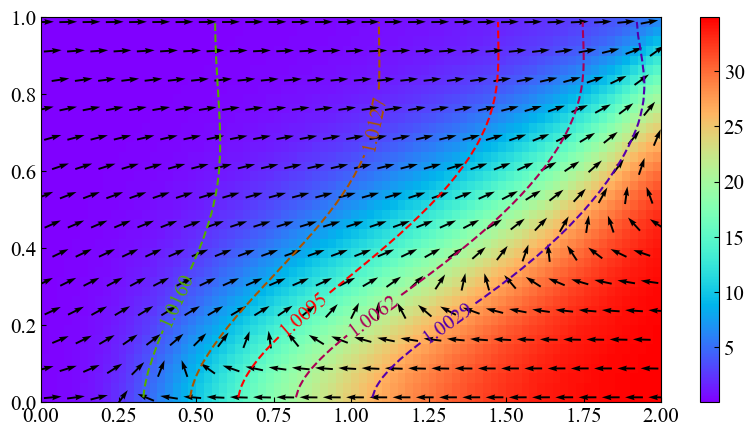

In [19]:

head = gwf.oc.output.head().get_alldata()
concentration = gwt.oc.output.concentration().get_alldata()
# gwt_budget = gwt.oc.output.budget().get_data(kstpkper = (0, 0))
gwf_budget = gwf.oc.output.budget().get_data(kstpkper=(0, 0))


def plot_results(model, a):
    config = {'font.family': 'Times New Roman', 'font.size': 15, 'xtick.direction': 'in', 'ytick.direction': 'in',
              'mathtext.fontset': 'stix', 'savefig.dpi': 300}
    plt.rcParams.update(config)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    pmv = flopy.plot.PlotCrossSection(model=model, ax=ax, line={"row": 0})
    pmv.plot_grid(ax=ax, color=".5", alpha=0.2)

    plot_array = pmv.plot_array(a, cmap='rainbow')
    plt.colorbar(plot_array)

    plot_contour_array = pmv.contour_array(
        head[499], leavels=np.arange(1, 1.03, 0.005), cmap="brg", linestyles="--")
    plt.clabel(plot_contour_array, fmt=r'%.4f')
#     plt.colorbar(plot_contour_array)

#     pmv.plot_bc(package = gwf.get_package("GHB-1"), color = 'green')
#     pmv.plot_bc(package = gwf.get_package("WEL-1"), color = 'black')
#     pmv.plot_inactive(ibound = gwf.modelgrid.idomain, color_noflow = 'black')

    spdis = gwf.oc.output.budget().get_data(text='DATA-SPDIS')[499]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    pmv.plot_vector(
        qx, qy, qz, head=head[499], normalize=True, kstep=3, hstep=3, color="black")


plot_results(model=gwt, a=concentration[499])